## Machine Learning- Kaggle Competition - Notebook

### Student Name : Aman Niyaz

### ID: 20135262  
#### Group Name: Linear8
#### Group No.: 8


#### Summary
A dataset of houses with its properties for Dublin based area is given. Our task is to predict the **_price_** for a particular house depending on its features such as _area_, _surface_, _beds_, _bathrooms_, _property_type_, _longitude_, _latitude_ etc.

I have implemented a solution based on it's numrical columns and one string column that is _property_type_ which I have encode to the numbers. I applied feature selection and data preprocessing to handle data impution. I had to be very careful about the filling of Null values. As I saw that most of the null values in _beds_ and _bathrooms_ has the surface value higher than 1000,  I replaced them with 0. Again, null values for price is filled with the average value of the price when the surface is much higher ie 2500. I filled the **property_type** null values with _'site'_. 
I tried different models and checked the cross validation score and MAPE score. Linear Regression behaved very bad. Then I tried SVR but also didn’t predict the values nicely. I was getting higher value of MAPE in case of SVR. Then I tried **Random forest Regressor** tuning various parameters. I got a good score of MAPE in case of Random Forest around **19.69**. Then lastly I tried Gradient Boosting Regressor where I got the least score of MAPE: **5.98**. That’s the solution I submitted in the Kaggle at the end. Currently our team is in the _First Position_. I got a good score for Cross Validation Score as well around 72%. That means my model is not over fitting.

My model could improve If I had used Images of the houses using Neural Networks. But as my Machine is not that capable, I didn't try on them. 


In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

## load datasets

In [2]:
dftrain = pd.read_csv("kaggle-grp8/dataset_csv/train.csv",index_col='ad_id',  encoding='latin1')
dftest  = pd.read_csv( "kaggle-grp8/dataset_csv/test.csv",index_col='ad_id')

In [3]:
dftrain.tail()

,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
ad_id,,,,,,,,,,,,,,,,
12428232,Ballsbridge,2.0,2.0,C3,Dublin,Sherry FitzGerald are delighted to present Apa...,prod,NaN,Prime Location\nManagement Co: Core Property M...,53.338738,-6.237199,NaN,415000.0,sale,apartment,56.0
12428240,Rialto,1.0,3.0,B2,Dublin,Property Team Patrick Moran is delighted to pr...,prod,NaN,Totally refurbished to the highest standard. \...,53.335793,-6.294268,NaN,485000.0,sale,terraced,101.0
12428247,Smithfield,1.0,2.0,C3,Dublin,Earnest estate agents are delighted to present...,prod,Wired for Cable Television,OVERLOOKING THE RIVER LIFFEY \n3RD FLOOR APART...,53.346098,-6.276856,NaN,299000.0,sale,apartment,55.6
12428254,Foxrock,2.0,3.0,C3,Dublin,Janet Carroll Estate Agents are pleased to pre...,prod,"Parking,Gas Fired Central Heating",None,53.273518,-6.178500,NaN,495000.0,sale,end-of-terrace,97.0
12428358,Terenure,2.0,3.0,D2,Dublin,ON VIEW SATURDAY 7 TH MARCH 2020 11:30 AM - 12...,prod,NaN,Charming three-bedroom family home\nMinutes aw...,53.310073,-6.325158,NaN,525000.0,sale,semi-detached,129.3


## Data Cleaning, Features selection and preprocessing

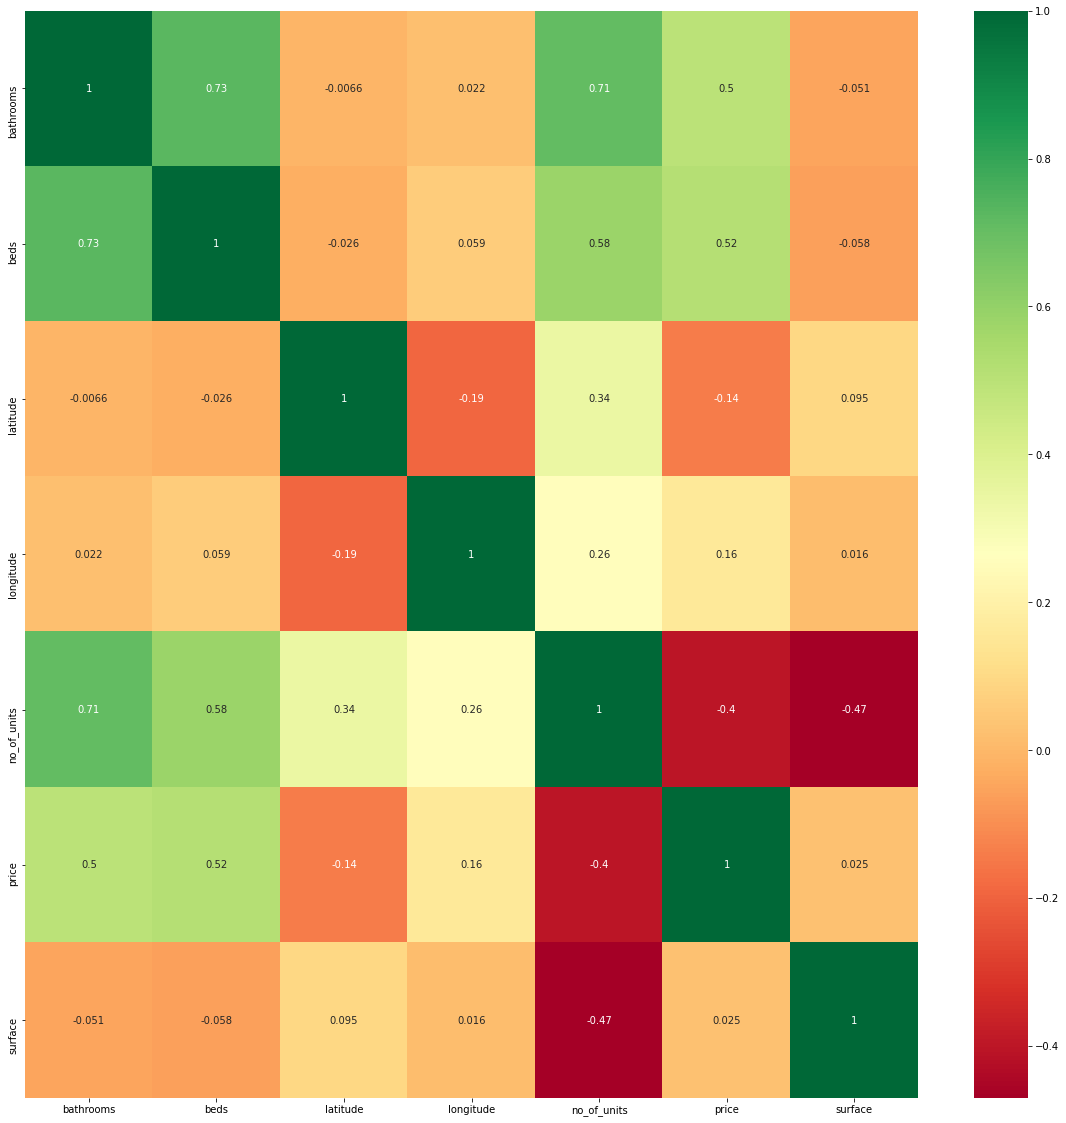

In [6]:
corrmat = dftrain.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(dftrain[top_corr_features].corr(),annot=True,cmap="RdYlGn")

plt.savefig('heatmap.png')

In [5]:
#choosing these few columns for our prediction
dftrain_subset = dftrain[["bathrooms","beds", "surface","longitude","latitude", "property_type", "price"]].copy()

### Handling Data Imputation 

In [7]:
dftrain_subset.isna().sum()

bathrooms         51
beds              51
surface          551
longitude          0
latitude           0
property_type     51
price             90
dtype: int64

##### handling surface values

In [10]:
surface_max = dftrain_subset['surface'].max()
surface_min = dftrain_subset['surface'].min()
surface_avg = dftrain_subset['surface'].mean()
surface_mdn = dftrain_subset['surface'].median()
print(f"Surface Values:----->\nMax: {surface_max}\nMin: {surface_min}\nAverage: {surface_avg}\nMedian: {surface_mdn}")

Surface Values:----->
Max: 182108.539008
Min: 3.4
Average: 318.8517865061251
Median: 100.0


In [35]:
surface_high = dftrain_subset[dftrain_subset['surface'] >= 1000]
surface_high

,bathrooms,beds,surface,longitude,latitude,property_type,price
ad_id,,,,,,,
11471682,0.0,0.0,1618.742569,-6.101097,53.546950,site,375000.0
11675753,1.0,4.0,72236.387140,-6.343483,53.474502,bungalow,1100000.0
11701116,0.0,0.0,1618.742569,-6.115498,53.499991,site,150000.0
11703559,0.0,0.0,80937.128448,-6.125436,53.503031,site,380000.0
11958173,0.0,0.0,2023.428211,-6.382349,53.391614,site,NaN
11965032,1.0,2.0,6705.000000,-6.377356,53.386540,bungalow,425000.0
11967532,0.0,0.0,1497.336876,-6.408055,53.401792,site,NaN
11968401,0.0,0.0,16187.425690,-6.383562,53.566867,site,175000.0
12051220,1.0,3.0,1195.000000,-6.152538,53.283656,end-of-terrace,465000.0


In [36]:
surface_high[surface_high['property_type'] == 'site']

,bathrooms,beds,surface,longitude,latitude,property_type,price
ad_id,,,,,,,
11471682,0.0,0.0,1618.742569,-6.101097,53.546950,site,375000.0
11701116,0.0,0.0,1618.742569,-6.115498,53.499991,site,150000.0
11703559,0.0,0.0,80937.128448,-6.125436,53.503031,site,380000.0
11958173,0.0,0.0,2023.428211,-6.382349,53.391614,site,NaN
11967532,0.0,0.0,1497.336876,-6.408055,53.401792,site,NaN
11968401,0.0,0.0,16187.425690,-6.383562,53.566867,site,175000.0
12115660,0.0,0.0,3116.079445,-6.292842,53.348306,site,NaN
12115982,0.0,0.0,4046.856422,-6.246421,53.314988,site,NaN
12160238,0.0,0.0,1011.714106,-6.321978,53.341002,site,160000.0


In [38]:
dftrain_subset['surface'] = dftrain_subset['surface'].fillna(surface_high['surface'].mean())

#### handling beds, bathrooms, property_type and price

In [52]:
beds_baths = dftrain_subset[dftrain_subset['surface'] >= 2500]
beds_baths.isna().sum()

bathrooms         0
beds              0
surface           0
longitude         0
latitude          0
property_type     0
price            63
dtype: int64

In [47]:
dftrain_subset.isna().sum()

bathrooms        51
beds             51
surface           0
longitude         0
latitude          0
property_type    51
price            90
dtype: int64

In [49]:
dftrain_subset['beds'] = dftrain_subset['beds'].fillna(0)
dftrain_subset['bathrooms'] = dftrain_subset['bathrooms'].fillna(0)
dftrain_subset['property_type'] = dftrain_subset['property_type'].fillna('site')
dftrain_subset

,bathrooms,beds,surface,longitude,latitude,property_type,price
ad_id,,,,,,,
996887,0.0,0.0,16373.887449,-6.149329,53.418216,site,NaN
999327,0.0,0.0,16373.887449,-6.454935,53.364917,site,NaN
999559,0.0,0.0,16373.887449,-6.313821,53.273447,site,NaN
9102986,0.0,0.0,16373.887449,-6.210914,53.608167,site,NaN
9106028,0.0,0.0,16373.887449,-6.181527,53.262531,site,NaN
...,...,...,...,...,...,...,...
12428232,2.0,2.0,56.000000,-6.237199,53.338738,apartment,415000.0
12428240,1.0,3.0,101.000000,-6.294268,53.335793,terraced,485000.0
12428247,1.0,2.0,55.600000,-6.276856,53.346098,apartment,299000.0


In [55]:
price_max = beds_baths['price'].max()
price_min = beds_baths['price'].min()
price_avg = beds_baths['price'].mean()
price_mdn = beds_baths['price'].median()
print(f"Surface Values:----->\nMax: {price_max}\nMin: {price_min}\nAverage: {price_avg}\nMedian: {price_mdn}")

Surface Values:----->
Max: 4500000.0
Min: 75000.0
Average: 390788.1225296443
Median: 302500.0


In [56]:
dftrain_subset['price'] = dftrain_subset['price'].fillna(price_avg)

In [57]:
dftrain_subset

,bathrooms,beds,surface,longitude,latitude,property_type,price
ad_id,,,,,,,
996887,0.0,0.0,16373.887449,-6.149329,53.418216,site,390788.12253
999327,0.0,0.0,16373.887449,-6.454935,53.364917,site,390788.12253
999559,0.0,0.0,16373.887449,-6.313821,53.273447,site,390788.12253
9102986,0.0,0.0,16373.887449,-6.210914,53.608167,site,390788.12253
9106028,0.0,0.0,16373.887449,-6.181527,53.262531,site,390788.12253
...,...,...,...,...,...,...,...
12428232,2.0,2.0,56.000000,-6.237199,53.338738,apartment,415000.00000
12428240,1.0,3.0,101.000000,-6.294268,53.335793,terraced,485000.00000
12428247,1.0,2.0,55.600000,-6.276856,53.346098,apartment,299000.00000


In [58]:
dftrain_subset.isna().sum()

bathrooms        0
beds             0
surface          0
longitude        0
latitude         0
property_type    0
price            0
dtype: int64

#### Encoding property_type to numericals

In [59]:
dftrain_subset['property_type'].uniqueue()

array(['site', 'detached', 'semi-detached', 'apartment', 'terraced',
       'bungalow', 'townhouse', 'end-of-terrace', 'duplex', 'studio'],
      dtype=object)

In [60]:
property_type_dict = {'detached': 1, 'semi-detached': 2, 'apartment': 3, 'terraced': 4, 'site': 5, 'bungalow': 6, 'townhouse': 7, 'end-of-terrace': 8, 'duplex': 9, 'studio': 10}

In [62]:
dftrain_subset['property_type'] = dftrain_subset['property_type'].map(property_type_dict)
dftrain_subset

,bathrooms,beds,surface,longitude,latitude,property_type,price
ad_id,,,,,,,
996887,0.0,0.0,16373.887449,-6.149329,53.418216,5,390788.12253
999327,0.0,0.0,16373.887449,-6.454935,53.364917,5,390788.12253
999559,0.0,0.0,16373.887449,-6.313821,53.273447,5,390788.12253
9102986,0.0,0.0,16373.887449,-6.210914,53.608167,5,390788.12253
9106028,0.0,0.0,16373.887449,-6.181527,53.262531,5,390788.12253
...,...,...,...,...,...,...,...
12428232,2.0,2.0,56.000000,-6.237199,53.338738,3,415000.00000
12428240,1.0,3.0,101.000000,-6.294268,53.335793,4,485000.00000
12428247,1.0,2.0,55.600000,-6.276856,53.346098,3,299000.00000


In [63]:
dftest['property_type'].unique()

array(['bungalow', 'terraced', 'semi-detached', 'apartment', 'detached',
       'end-of-terrace', 'townhouse', 'duplex', 'site', 'studio'],
      dtype=object)

In [64]:
dftest['property_type'] = dftest['property_type'].map(property_type_dict)
dftest

,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface
ad_id,,,,,,,,,,,,,,,
12373510,Skerries,2.0,4.0,G,Dublin,"It's all in the name ""Island View"";. Truly won...",prod,"Parking,Alarm,Oil Fired Central Heating",Breath-taking panoramic views radiate from thi...,53.566881,-6.101148,NaN,sale,6,142.0
12422623,Lucan,2.0,3.0,C1,Dublin,REA McDonald - Lucan' s longest established es...,prod,NaN,Gas fired central heating.\nDouble glazed wind...,53.362992,-6.452909,NaN,sale,4,114.0
12377408,Swords,3.0,4.0,B3,Dublin,REA Grimes are proud to present to the market ...,prod,NaN,Pristine condition throughout\nHighly sought-a...,53.454198,-6.262964,NaN,sale,2,172.0
12420093,Lucan,4.0,3.0,A3,Dublin,"REA McDonald, Lucan' s longest established est...",prod,NaN,A-rated home within a short walk of Lucan Vill...,53.354402,-6.458647,NaN,sale,2,132.4
12417338,Clondalkin,1.0,3.0,E2,Dublin,"Hibernian Auctioneers are delighted to bring, ...",prod,"Parking,Gas Fired Central Heating,Wired for Ca...",Mature Location \nGas Heating \nClose to Ameni...,53.336530,-6.393587,NaN,sale,2,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12369815,Ringsend,1.0,2.0,NaN,Dublin,***SUPERB LOCATION / PRIVATE PARKING OPTION AV...,prod,NaN,Adjacent to Grand Canal Dock\nClose to a host ...,53.342207,-6.226101,NaN,sale,3,65.0
12416011,Cabinteely,3.0,5.0,E1,Dublin,"OPEN VIEWING SATURDAY 7TH MARCH, 10.00AM - 10....",prod,"Parking,Alarm,Oil Fired Central Heating",Excellently presented 5 bedroom family home\nE...,53.261475,-6.147720,NaN,sale,1,191.3
12232222,Artane,1.0,3.0,G,Dublin,Sherry FitzGerald is delighted to present to t...,prod,NaN,Detached Family Home\nOnly One Owner\nMature C...,53.391619,-6.205157,NaN,sale,1,105.0


### Preparing data for the model

In [65]:
## Training data
X = dftrain_subset[["bathrooms","beds", "surface","longitude","latitude", "property_type"]]
y = dftrain_subset['price']
## Test data
Xtest = dftest[["bathrooms","beds", "surface","longitude","latitude", "property_type"]]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [66]:
## Function to calcuate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Training Models
We try different models so that we can analyze whihc model gives better solution

### 1. (Polynomial) Linear Regression

In [78]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression().fit(X_train, y_train)

scores_linreg = cross_val_score(linreg, X, y, cv=10)
print("CV Score: ", scores_linreg.mean())
y_tr_pred = linreg.predict(X)
y_te_pred = linreg.predict(Xtest)
mape = mean_absolute_percentage_error(y,y_tr_pred)
print("MAPE: ", mape)

CV Score:  0.11809815204609224
MAPE:  42.66746495724645


## 2. SVM - Regressor

In [102]:
svr = SVR(C=10, epsilon=0.5, gamma=0.1, kernel='linear').fit(X_train, y_train)

#Cross Validation Score
scores_svr = cross_val_score(svr, X, y, cv=10)
print("CV Score: ", scores_svr.mean())
y_tr_pred = svr.predict(X)
y_te_pred = svr.predict(Xtest)
mape = mean_absolute_percentage_error(y,y_tr_pred)
print("MAPE: ", mape)

CV Score:  0.016159111079008047
MAPE:  38.16686339483604


## 3. Random Forest Regressor

In [103]:
randforest = RandomForestRegressor(max_depth=10, max_features='auto', n_estimators=400).fit(X_train, y_train)

#Cross Validation Score
scores_randforest = cross_val_score(randforest, X, y, cv=10)
print("CV Score: ", scores_randforest.mean())
y_tr_pred = randforest.predict(X_test)
y_te_pred = randforest.predict(Xtest)
# MAPE Values
mape = mean_absolute_percentage_error(y_test,y_tr_pred)
print("MAPE: ", mape)

CV Score:  0.6341699607202578
MAPE:  19.690040814435278


## 4. Grandient Boosting Regressor

In [100]:
gbr = GradientBoostingRegressor(n_estimators = 400, max_depth = 20, min_samples_split = 4,
                                            learning_rate = 0.01, loss = 'lad',criterion='mse').fit(X_train,y_train)
scores_gbr = cross_val_score(gbr, X, y, cv=10)

In [101]:
print("CV Score: ", scores_gbr.mean())
y_tr_pred = gbr.predict(X)
y_te_pred = gbr.predict(Xtest)
mape = mean_absolute_percentage_error(y,y_tr_pred)
print("MAPE: ", mape)

CV Score:  0.7233222197718384
MAPE:  5.988455128205228


## Best Score
The above MAPE score and CV score of Gradient Boosting Regressor tells that my model is not overfitting. Therefore, I submitted it at the end in Kaggle and I received the MAPE score for testing as **18.42104**

## Prepare predictions for Kaggle

In [99]:
Prediction = pd.DataFrame()
Prediction.insert(0, 'Id', dftest.index.values.astype(int))
Prediction.insert(1, 'Predicted', y_te_pred)
Prediction.to_csv("submit_linear8_v22.csv", index=False)
Prediction

,Id,Predicted
0,12373510,480666.505153
1,12422623,333031.034864
2,12377408,541983.418270
3,12420093,377419.539719
4,12417338,248392.344588
...,...,...
495,12369815,382801.328128
496,12416011,948411.842581
497,12232222,374084.086363
498,11905630,672039.438380
